In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [35]:
rng = np.random.default_rng()

In [36]:
img_size = 28 # width/height of an image
train_len = 60000
test_len = 10000

In [37]:
def load_images():
    f = open('train-images.idx3-ubyte', 'rb')
    top = f.read(16) # skipping magic number and metadata
    images_b = f.read(img_size * img_size * train_len)
    f.close()
    train_X_full = np.frombuffer(images_b, dtype=np.uint8)
    train_X_full = train_X_full.reshape(train_len, img_size, img_size)
    print("Full Train X shape: ", train_X_full.shape)

    f = open('t10k-images.idx3-ubyte', 'rb')
    top = f.read(16)
    images_b = f.read(img_size * img_size * test_len)
    f.close()
    test_X = np.frombuffer(images_b, dtype=np.uint8)
    test_X = test_X.reshape(test_len, img_size, img_size)
    print("Test X shape: ", test_X.shape)

    return (train_X_full, test_X)

def load_labels():
    f = open('train-labels.idx1-ubyte', 'rb')
    top = f.read(8)
    labels_b = f.read(train_len)
    train_y_full = np.frombuffer(labels_b, dtype=np.uint8)
    print("Full Train Y shape: ", train_y_full.shape)

    f = open('t10k-labels.idx1-ubyte', 'rb')
    top = f.read(8)
    labels_b = f.read(test_len)
    test_y = np.frombuffer(labels_b, dtype=np.uint8)
    print("Test Y shape: ", test_y.shape)

    return (train_y_full, test_y)

def split_training(train_X_full, train_y_full, train_part=0.75):
    stopat = int(np.floor(train_len * train_part))
    train_X = train_X_full[:stopat, :, :]
    train_y = train_y_full[:stopat]
    val_X = train_X_full[stopat:, :, :]
    val_y = train_y_full[stopat:]
    return (train_X, train_y, val_X, val_y)

def preprocess_images(train_X, val_X, test_X):
    train_X = (train_X / 255) - 0.5
    val_X = (val_X / 255) - 0.5
    test_X = (test_X / 255) - 0.5
    return (train_X, val_X, test_X)

In [38]:
class CNN:
    def __init__(self):
        self.layers = []

    def addLayer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        layer_data = X # initial data
        for layer in self.layers:
            layer_data = layer.forward(layer_data) # saving output of layer as input for next one
        return layer_data

    def backward(self, y):
        error = y
        for layer in reversed(self.layers):
            error = layer.backward(error)
        return error

    def prepare_minibatches(self, X, y, size=32, shuffle=True):
        if shuffle:
            idx = np.arange(0, X.shape[0])
            idx = np.random.permutation(idx)
            X = X[idx, :]
            y = y[idx]

        batch_num = np.ceil(X.shape[0] / size)
        
        X_batches = np.array_split(X, batch_num)
        y_batches = np.array_split(y, batch_num)

        return (X_batches, y_batches)

    def loss(self, X, y):
        yhat = self.forward(X)
        loss = np.mean(-np.log(np.clip(yhat[np.arange(yhat.shape[0]), y], 10e-10, 1))) # clipping ar 10e-10 at lower end because log0 is undefined
        return loss

    def fit(self, X, y, epochs=3, batch_size=32, val_X=None, val_y=None):
        train_losses = []
        val_losses = []
        for i in range(epochs):
            X_batches, y_batches = self.prepare_minibatches(X, y, batch_size) # arrays with shuffled X and y split into batches of given size
            for X_mini, y_mini in zip(X_batches, y_batches):
                result = self.forward(X_mini)
                self.backward(y_mini)
            train_losses.append(self.loss(X, y)) # keeping track of losses on each epoch
            if val_X is not None and val_y is not None: # validation losses as well if present
                val_losses.append(self.loss(val_X, val_y))
                print("Epoch ", i + 1, ", Loss: ", train_losses[-1], " Val loss: ", val_losses[-1])
            else:
                print("Epoch ", i + 1, ", Loss: ", train_losses[-1])
        if val_X is not None and val_y is not None:
            return (train_losses, val_losses)
        return train_losses
        
    def predict(self, X):
        probs = self.forward(X)
        return probs

In [39]:
class ConvolutionLayer:
    def __init__(self, input_shape, filt_num, filt_size, eta=0.001, beta1=0.9, beta2=0.999, decay_step=1000):
        self.filt_num = filt_num
        self.filt_size = filt_size
        weights_std = np.sqrt(2 / np.prod(input_shape))
        self.weights = rng.normal(scale=weights_std, size=(filt_size, filt_size, filt_num))
        self.biases = np.zeros((filt_num))
        self.i_size = input_shape[0] - self.filt_size + 1
        self.j_size = input_shape[1] - self.filt_size + 1
        self.t = 0 # time step measures for Adam optimizer and to decay learning rate
        self.eta = eta
        self.lr = eta
        self.decay_step = decay_step # Amount of time steps required to decay learning rate once
        self.m_f = 0
        self.m_b = 0
        self.v_f = 0
        self.v_b = 0
        self.beta1 = beta1
        self.beta2 = beta2

    def forward(self, X):
        self.input = X # shape (N, 28, 28)
        self.batch_size = X.shape[0]
        output = np.zeros((self.batch_size, self.i_size, self.j_size, self.filt_num))
        for i in np.arange(self.i_size):
            for j in np.arange(self.j_size):
                    output[:, i, j, :] = np.sum(np.flip(X[:, i: i+self.filt_size, j: j+self.filt_size, np.newaxis], axis=(1,2)) * self.weights + self.biases, axis=(1,2))
        return output # shape (N, 26, 26, 8)

    def backward(self, error):
        self.t += 1
        
        # input_error = np.zeros_like(self.input) # Not used because there are no layers before convolution layer
        dj_df = np.zeros_like(self.weights) # derivative of loss w.r.t filter weights
        dj_db = np.zeros_like(self.biases)
        for i in np.arange(self.i_size):
            for j in np.arange(self.j_size):
                    dj_df += np.sum((np.flip(self.input[:, i: i+self.filt_size, j: j+self.filt_size, np.newaxis], axis=(1,2)) * error[:, i, j, :].reshape(-1, 1, 1, self.filt_num)), axis=(0,))
                    dj_db += np.sum(error[:, i, j, :], axis=(0,))
                    # input_error[:, i:i + self.filt_size, j:j + self.filt_size] += np.flip(self.weights[np.newaxis, :, :, k]) * error[:, i, j, k, np.newaxis, np.newaxis]

        if self.t % self.decay_step == 0:
            self.lr = max(self.eta * (0.5 ** (self.t // self.decay_step)), self.eta * 1e-3) # some minimum learning rate which is eta / 1e-3 to prevent getting too small

        self.m_f = (1 - self.beta1) * dj_df + self.beta1 * self.m_f # moving averages for Adam
        self.m_b = (1 - self.beta1) * dj_db + self.beta1 * self.m_b
        self.v_f = (1 - self.beta2) * np.square(dj_df) + self.beta2 * self.v_f # exponential moving averages for Adam
        self.v_b = (1 - self.beta2) * np.square(dj_db) + self.beta2 * self.v_b

        m_f_hat = self.m_f / (1 - self.beta1 ** self.t) # dealing with zero bias in the beginning
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_f_hat = self.v_f / (1 - self.beta2 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
        
        self.weights -= self.lr * m_f_hat / (np.sqrt(v_f_hat) + 1e-8)
        self.biases -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + 1e-8)
        
        return 0 # did not calculate input error for resource optimization

In [40]:
class ReluLayer:
    def forward(self, X):
        self.input = X # shape (N, 26, 26, 8)
        self.output = np.maximum(np.zeros_like(X), X)
        return self.output # shape (N, 26, 26, 8)

    def backward(self, error):
        input_error = error * (self.input > 0).astype(float)
        return input_error # shape (N, 26, 26, 8)

In [41]:
class PoolingLayer:
    def __init__(self, input_shape, filt_size, stride):
        self.input_shape = input_shape
        self.filt_size = filt_size
        self.stride = stride
        self.pooled_size = int((input_shape[0] - filt_size) / stride + 1)

    def forward(self, X):
        self.input = X # shape (N, 26, 26, 8)
        output = np.zeros((X.shape[0], self.pooled_size, self.pooled_size, self.input_shape[-1]))
        for i in np.arange(self.pooled_size):
            for j in np.arange(self.pooled_size):
                output[:, i, j, :] = np.amax(X[:, i*self.filt_size:i*self.filt_size+self.stride, j*self.filt_size:j*self.filt_size+self.stride, :], axis=(1, 2))
        return output # shape (N, 13, 13, 8)

    def backward(self, error): # Can be optimized to reduce python loops I think, but quite cumbersome
        input_error = np.zeros_like(self.input)
        for b in np.arange(self.input.shape[0]):
            for i in np.arange(self.pooled_size):
                for j in np.arange(self.pooled_size):
                    for k in np.arange(self.input_shape[-1]):
                        max_idx_flat = np.argmax(self.input[b, i*self.filt_size:i*self.filt_size+self.stride, j*self.filt_size:j*self.filt_size+self.stride, k])
                        max_idx = np.unravel_index(max_idx_flat, (self.stride, self.stride))
                        input_error[b, i*self.filt_size+max_idx[0], j*self.filt_size+max_idx[1], k] = error[b, i, j, k]
        return input_error # shape (N, 26, 26, 8)

In [42]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, X):
        return X.reshape(-1, np.prod(self.input_shape)) # shape (N, 1352)

    def backward(self, error):
        return error.reshape((-1,) + self.input_shape) # concat -1 to the beginning because of mini-batch mode
        # shape (Nx13x13x8)

In [43]:
class DenseLayer:
    def __init__(self, input_num, units, eta=0.001, beta1=0.9, beta2=0.999, decay_step=1000):
        self.input_shape = input_num # Expects 1D input (flatten layer used)
        weights_std = np.sqrt(2 / self.input_shape)
        self.weights = rng.normal(scale=weights_std, size=(self.input_shape, units)) # shape (1352, 10)
        self.biases = np.zeros((1, units))
        self.t = 0
        self.eta = eta
        self.lr = eta
        self.decay_step = decay_step
        self.m_w = 0
        self.m_b = 0
        self.v_w = 0
        self.v_b = 0
        self.beta1 = beta1
        self.beta2 = beta2

    def forward(self, X):
        self.input = X
        output = np.dot(X, self.weights) + self.biases
        return output

    def backward(self, error):
        self.t += 1
        
        input_error = np.dot(error, self.weights.T)
        dj_dw = np.dot(self.input.T, error)
        dj_db = np.sum(error, axis=0, keepdims=True)

        if self.t % self.decay_step == 0:
            self.lr = max(self.eta * (0.5 ** (self.t // self.decay_step)), self.eta * 1e-3)
        
        self.m_w = (1 - self.beta1) * dj_dw + self.beta1 * self.m_w
        self.m_b = (1 - self.beta1) * dj_db + self.beta1 * self.m_b
        self.v_w = (1 - self.beta2) * np.square(dj_dw) + self.beta2 * self.v_w
        self.v_b = (1 - self.beta2) * np.square(dj_db) + self.beta2 * self.v_b

        m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
        
        self.weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + 1e-8)
        self.biases -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + 1e-8)
        return input_error # shape (Nx1352)

In [44]:
class SoftmaxLayer:
    def forward(self, X):
        self.batch_size = int(X.shape[0])
        self.input = X # shape (N, 10)
        shifted_X = X - np.max(X, axis=1, keepdims=True)
        exp_x = np.exp(shifted_X)
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output # shape (N, 10)

    def backward(self, y): # y is a scalar
        y_onehot = np.zeros((self.batch_size, 10))
        y_onehot[np.arange(self.batch_size), y] = 1
        error = (self.output - y_onehot) / self.batch_size # normalized for batch size
        return error # shape (Nx10)

In [45]:
train_X_full, test_X = load_images()
train_y_full, test_y = load_labels()

train_X, train_y, val_X, val_y = split_training(train_X_full, train_y_full)
train_X, val_X, test_X = preprocess_images(train_X, val_X, test_X)

print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

Full Train X shape:  (60000, 28, 28)
Test X shape:  (10000, 28, 28)
Full Train Y shape:  (60000,)
Test Y shape:  (10000,)
train_X shape:  (45000, 28, 28)
train_y shape:  (45000,)
val_X shape:  (15000, 28, 28)
val_y shape:  (15000,)


In [46]:
# Shrink dataset to accelerate training
train_idx = np.array([], dtype='int32')
val_idx = np.array([], dtype='int32')
test_idx = np.array([], dtype='int32')
for i in range(10):
    idx = np.nonzero(train_y == i)[0].astype(int)
    train_idx = np.append(train_idx, np.random.permutation(idx[:300]))
    idx = np.nonzero(val_y == i)[0].astype(int)
    val_idx = np.append(val_idx, np.random.permutation(idx[:120]))
    idx = np.nonzero(test_y == i)[0].astype(int)
    test_idx = np.append(test_idx, np.random.permutation(idx[:120]))
print(len(train_idx))
print(len(val_idx))
print(len(test_idx))

3000
1200
1200


In [14]:
model = CNN() # small model
model.addLayer(ConvolutionLayer(input_shape=(28, 28), filt_num=8, filt_size=3, eta=0.005))
model.addLayer(ReluLayer())
model.addLayer(PoolingLayer(input_shape=(26,26,8), filt_size=2, stride=2))
model.addLayer(FlattenLayer(input_shape=(13,13,8)))
model.addLayer(DenseLayer(input_num=1352, units=10, eta=0.005))
model.addLayer(SoftmaxLayer())
model.fit(train_X[train_idx], train_y[train_idx], epochs=10, batch_size=32, val_X=val_X[val_idx], val_y=val_y[val_idx])

Epoch  1 , Loss:  0.3610162025849472  Val loss:  0.44630218834931557
Epoch  2 , Loss:  0.2651127506568085  Val loss:  0.3741532825368045
Epoch  3 , Loss:  0.24261084213205103  Val loss:  0.3890198161447052
Epoch  4 , Loss:  0.14480297579447382  Val loss:  0.31962506063331136
Epoch  5 , Loss:  0.11151086910389828  Val loss:  0.3123056078293062
Epoch  6 , Loss:  0.07926209277462114  Val loss:  0.301548456715962
Epoch  7 , Loss:  0.05729662789627982  Val loss:  0.30822449954989994
Epoch  8 , Loss:  0.03845730995696103  Val loss:  0.2879301273179661
Epoch  9 , Loss:  0.04197804189811896  Val loss:  0.34361114266783127
Epoch  10 , Loss:  0.030255494515187276  Val loss:  0.32369469321254046


([0.3610162025849472,
  0.2651127506568085,
  0.24261084213205103,
  0.14480297579447382,
  0.11151086910389828,
  0.07926209277462114,
  0.05729662789627982,
  0.03845730995696103,
  0.04197804189811896,
  0.030255494515187276],
 [0.44630218834931557,
  0.3741532825368045,
  0.3890198161447052,
  0.31962506063331136,
  0.3123056078293062,
  0.301548456715962,
  0.30822449954989994,
  0.2879301273179661,
  0.34361114266783127,
  0.32369469321254046])

In [ ]:
with open('model_mini.pickle', 'wb') as model_mini_file: 
    pickle.dump(model, model_mini_file) # saving small trained model

In [18]:
model = CNN() # big model
model.addLayer(ConvolutionLayer(input_shape=(28, 28), filt_num=8, filt_size=3, eta=0.005))
model.addLayer(ReluLayer())
model.addLayer(PoolingLayer(input_shape=(26,26,8), filt_size=2, stride=2))
model.addLayer(FlattenLayer(input_shape=(13,13,8)))
model.addLayer(DenseLayer(input_num=1352, units=10, eta=0.005))
model.addLayer(SoftmaxLayer())
model.fit(train_X, train_y, epochs=10, batch_size=32, val_X=val_X, val_y=val_y) # should have included full training data
# but it takes too long, >1 hr

Epoch  1 , Loss:  0.12936262755110506  Val loss:  0.1397207327517369
Epoch  2 , Loss:  0.08500557215326363  Val loss:  0.10434281115388583
Epoch  3 , Loss:  0.07247527015831375  Val loss:  0.09496969402630304
Epoch  4 , Loss:  0.06875881944612612  Val loss:  0.09196576147477663
Epoch  5 , Loss:  0.06741634928036695  Val loss:  0.09139068065307286
Epoch  6 , Loss:  0.06685945424986102  Val loss:  0.09082025775047287
Epoch  7 , Loss:  0.06668188082891463  Val loss:  0.09069433854669562
Epoch  8 , Loss:  0.06661344621357426  Val loss:  0.09064530625868177
Epoch  9 , Loss:  0.06654996492914173  Val loss:  0.09060615601527688
Epoch  10 , Loss:  0.06648764159023128  Val loss:  0.09057270358151241


([0.12936262755110506,
  0.08500557215326363,
  0.07247527015831375,
  0.06875881944612612,
  0.06741634928036695,
  0.06685945424986102,
  0.06668188082891463,
  0.06661344621357426,
  0.06654996492914173,
  0.06648764159023128],
 [0.1397207327517369,
  0.10434281115388583,
  0.09496969402630304,
  0.09196576147477663,
  0.09139068065307286,
  0.09082025775047287,
  0.09069433854669562,
  0.09064530625868177,
  0.09060615601527688,
  0.09057270358151241])

In [54]:
preds_distribution = model.predict(test_X)
preds = np.argmax(preds_distribution, axis=1)
print("Test accuracy: ", np.mean(preds == test_y) * 100)
print("Test loss: ", model.loss(test_X, test_y))

Test accuracy:  97.61
Test loss:  0.07724303549404923


In [20]:
with open('model.pickle', 'wb') as model_file:
    pickle.dump(model, model_file) # saving big trained model

In [51]:
with open('model.pickle', 'rb') as model_file:
    model = pickle.load(model_file) # can load pretrained model

In [55]:
confusion_matrix = np.zeros((10, 10)).astype(int)
for pred, actual in zip(preds, test_y):
    confusion_matrix[pred, actual] += 1

In [56]:
def plot_confusion_matrix(cm):
    labels = [str(i) for i in range(cm.shape[0])]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel='Actual',
           xlabel='Predicted')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")

    return ax

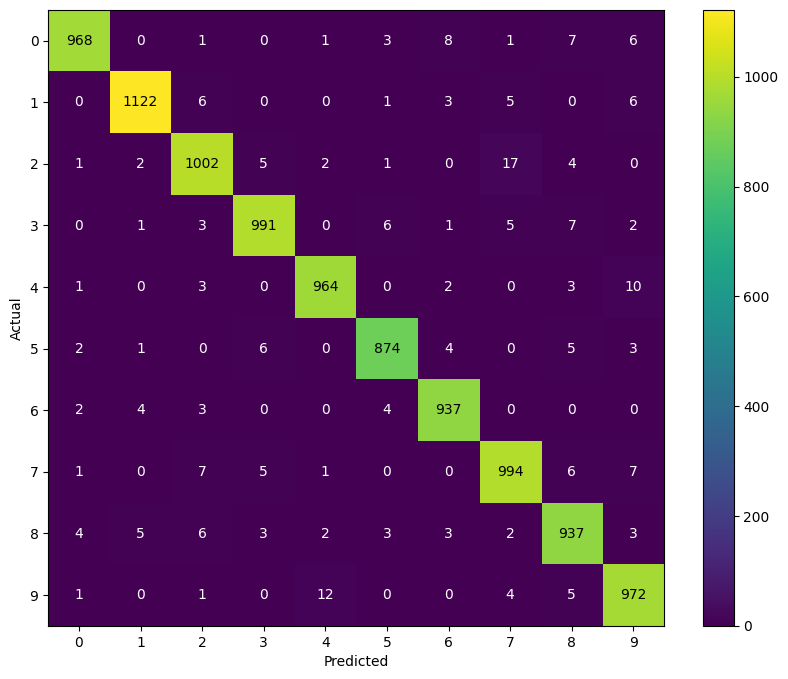

In [57]:
plot_confusion_matrix(confusion_matrix)
plt.show()

In [59]:
def matrix_to_images(X, y): # digits visualization
    print(X.shape)
    print(y.shape)
    images = X.reshape((-1, img_size, img_size))
    img_num = len(images)
    columns = min(5, img_num)
    rows = int(np.ceil(img_num / columns))
    fig = plt.figure(figsize=(4 * columns, 4 * rows))
    
    for i in np.arange(len(images)):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f"Image {i + 1}, Label: {y[i]}")

In [71]:
sample_2 = np.random.choice(np.nonzero(train_y_full == 2)[0], size=1) # some random samples for saliency via occlusion
sample_4 = np.random.choice(np.nonzero(train_y_full == 4)[0], size=1)
sample_9 = np.random.choice(np.nonzero(train_y_full == 9)[0], size=1)
samples = [sample_2[0], sample_4[0], sample_9[0]]
print(samples)

[19815, 53459, 44154]


In [72]:
saliency_maps = np.zeros((3, 26, 26))

for b in range(3):
    for i in range(26):
        for j in range(26):
            X_modified = train_X_full[samples[b]].copy()
            X_modified[i: i + 3, j : j + 3] = np.zeros((3, 3)) # placing a black patch on some area of image 
            saliency_maps[b, i, j] = np.argmax(model.predict(X_modified.reshape(-1, 28, 28))) # predicting with a patch

(3, 28, 28)
(3,)


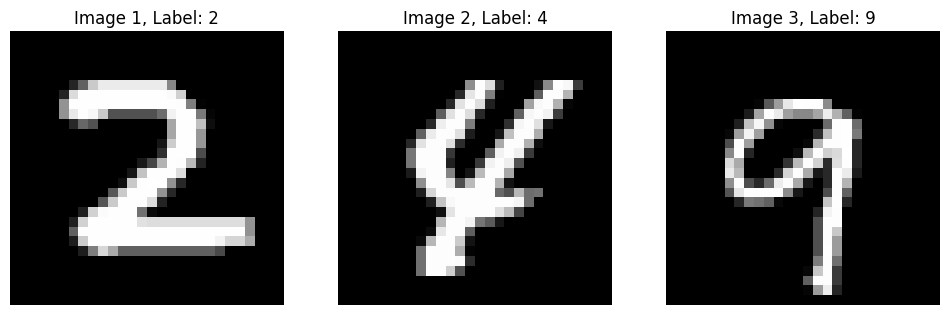

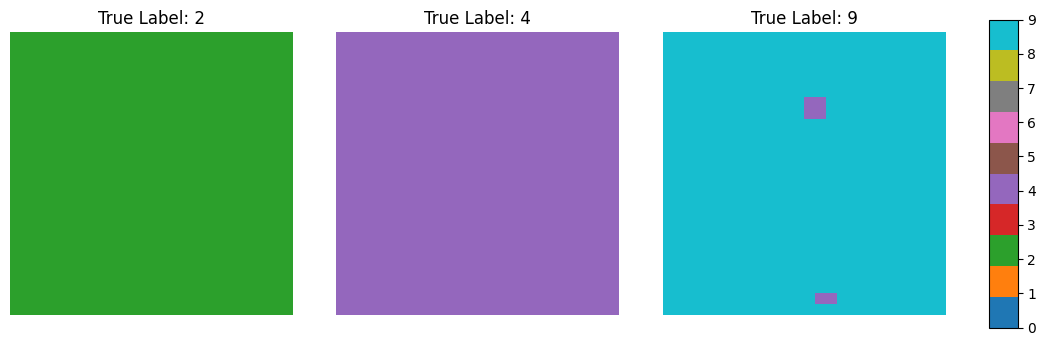

In [73]:
matrix_to_images(train_X_full[samples], train_y_full[samples])

fig = plt.figure(figsize=(4 * 3 + 1, 4 * 1)) # saliency via occlusion visualization

gs = plt.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1], figure=fig)
plt.tight_layout()

for i in np.arange(3):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(saliency_maps[i], cmap='tab10', vmin=0, vmax=9)
    ax.axis('off')
    ax.set_title(f"True Label: {train_y_full[samples[i]]}")

cax = fig.add_subplot(gs[0, 3])
nums = np.arange(10)
plt.colorbar(im, cax=cax, ticks=nums)